# ** ->> STANCE <<- **

In [54]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Load Stance training data**

In [55]:
#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/Fake_and_True.csv'
#PATH_TO_DATA =  '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/train-balanced-sarcasm.csv' # '../input/sarcasm/train-balanced-sarcasm.csv'  train-balanced-sarcasm.csv
#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/tweet.csv'
PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/stance_train_v1.csv'
#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/stance_test_v1.csv'

# **Set up environment**

In [56]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from matplotlib import pyplot as plt

In [57]:
train_df = pd.read_csv(PATH_TO_DATA) # , nrows=5500)

In [58]:
train_df.head()

,label,tweet
0,1,If a man demanded staff to get him an ice tea ...
1,0,"We're out here in G-town, and where are you #..."
2,2,If you're not watching @user speech right now ...
3,1,How can she live with herself? #Benghazi #SemST
4,0,Jimmy Fallon music playing. Thank you .... #Do...


# **Check balance of Stance database (an academic but clean Stance reference database)**

In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   620 non-null    int64 
 1   tweet   620 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


**Drop null rows**

In [60]:
train_df.dropna(subset=['tweet'], inplace=True)

# **Recheck balance**

In [61]:
train_df['label'].value_counts()

label
1    354
0    160
2    106
Name: count, dtype: int64

# **Split reference stance data into training and validation sections**

In [62]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['tweet'], train_df['label'], random_state=42)

## **EDA / Exploratory data analysis**

1.   true-neutral stance
2.   misinformation stance (mistakes)
3.   disinformation stance (lies)



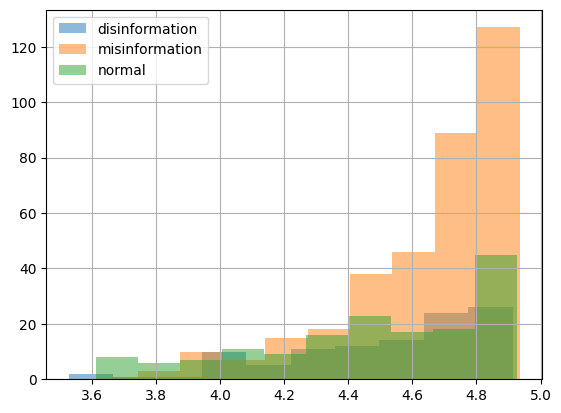

In [63]:
# Needs adjusting for three categories of labels 0,1,2 / true-neutral, misinformation(mistakes), disinformation(lies)

train_df.loc[train_df['label'] == 2, 'tweet'].str.len().apply(np.log1p).hist(label='disinformation', alpha=.5)
train_df.loc[train_df['label'] == 1, 'tweet'].str.len().apply(np.log1p).hist(label='misinformation', alpha=.5)
train_df.loc[train_df['label'] == 0, 'tweet'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [64]:
# from wordcloud import WordCloud, STOPWORDS

from wordcloud import WordCloud, STOPWORDS
#stop_words = set(STOPWORDS)

# **Word clouds**

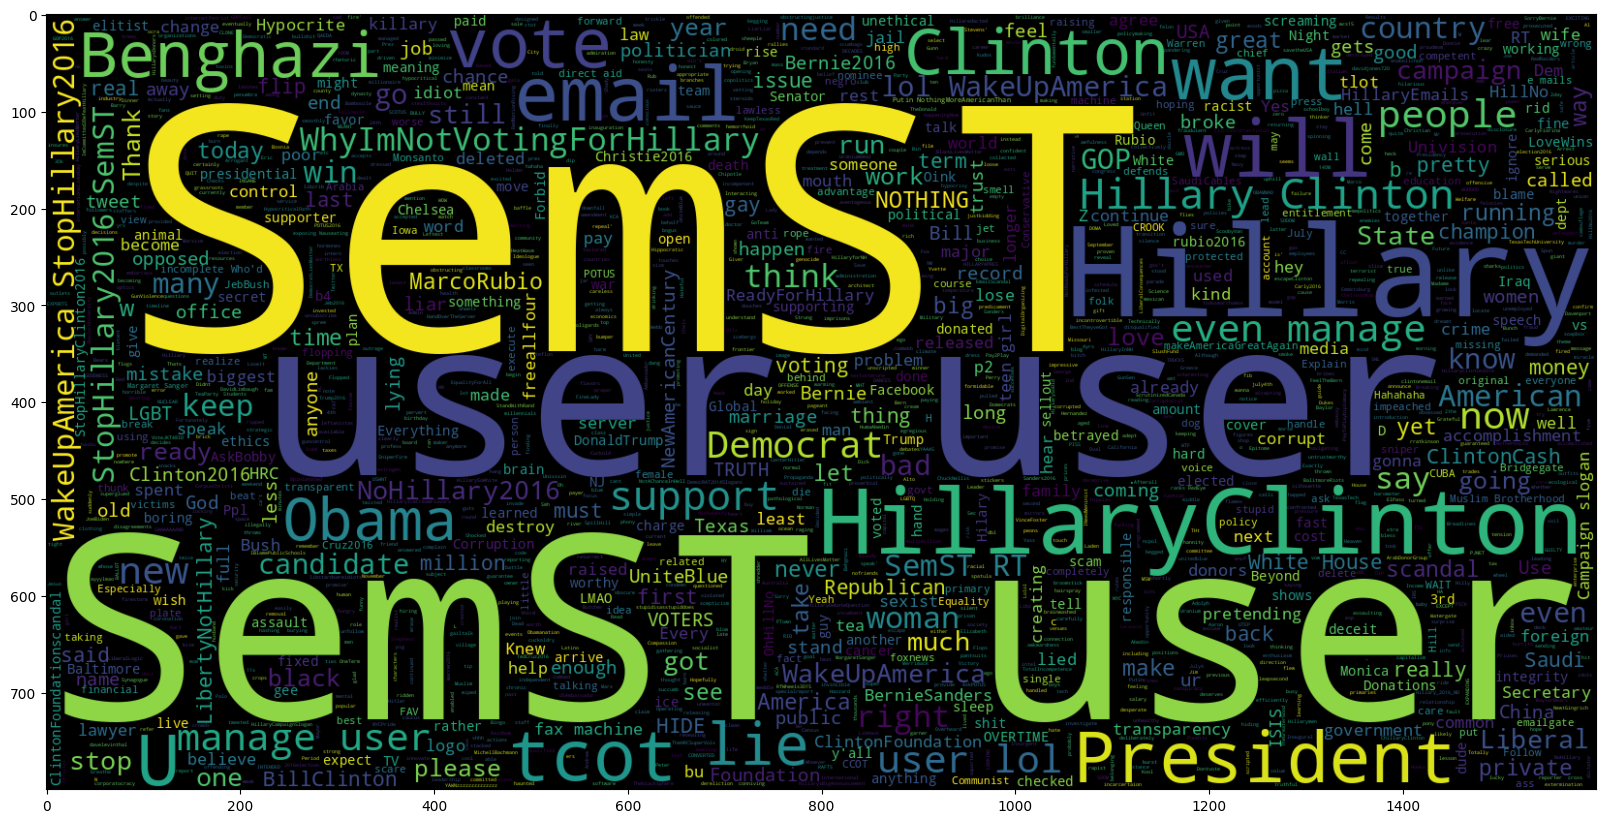

In [65]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join((train_df.loc[train_df.label == 1, "tweet"])))
plt.imshow(wc, interpolation = 'bilinear')

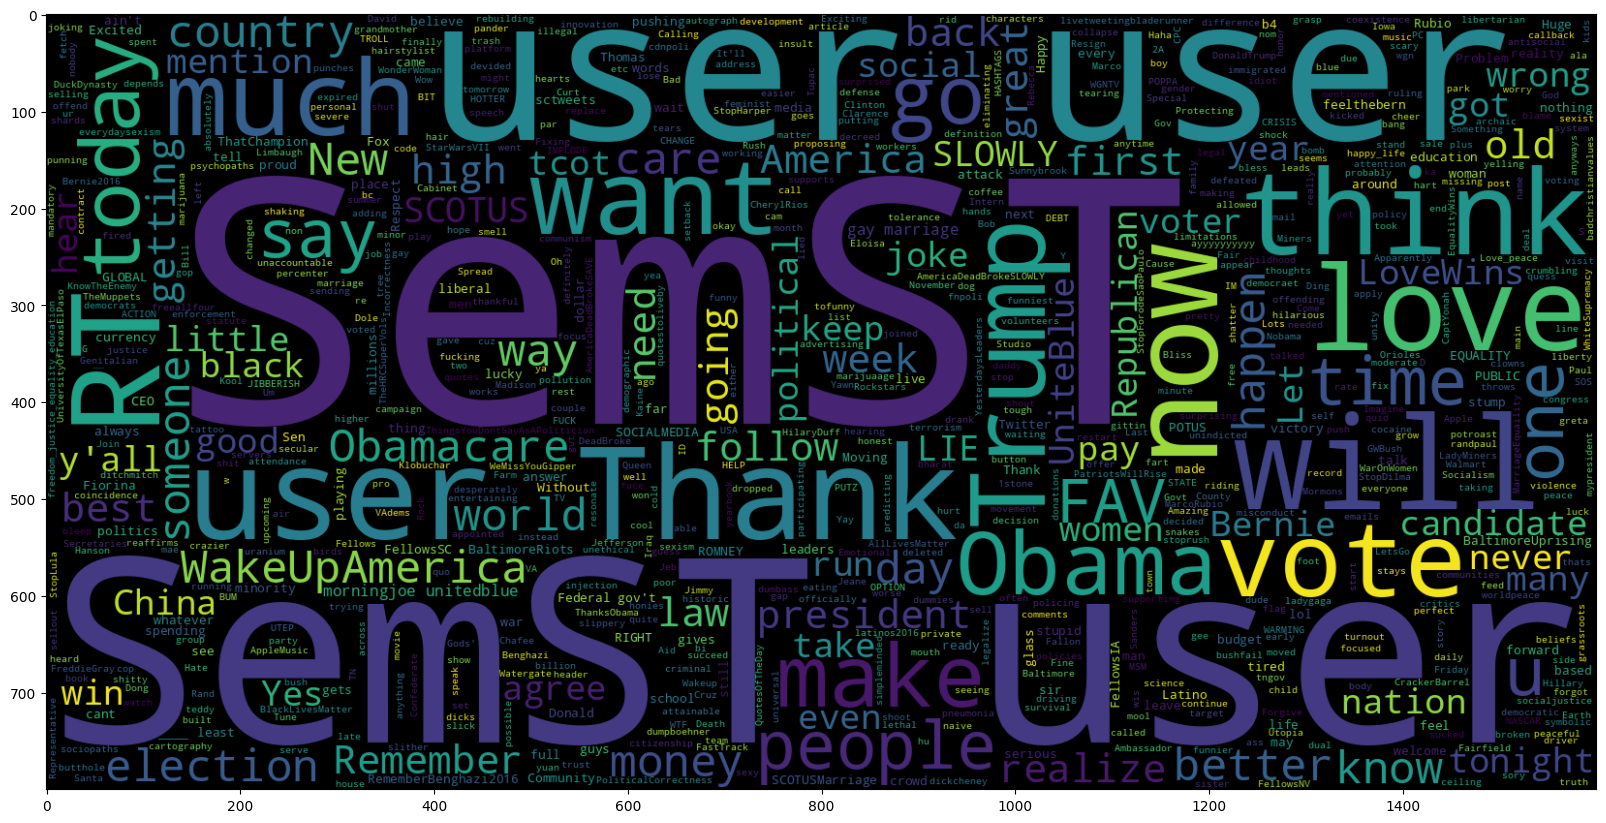

In [30]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 200 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join((train_df.loc[train_df.label == 0, "tweet"])))
plt.imshow(wc, interpolation = 'bilinear')


Let's analyze whether some subreddits are more "sarcastic" on average than others

# **Train the model**

1.   using first TF-iDF
2.   then Logistic regression
3.   then put both in to a pipeline



In [66]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs',
                           random_state=42, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf),
                                 ('logit', logit)])

In [67]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


CPU times: user 97.1 ms, sys: 117 ms, total: 214 ms
Wall time: 2.26 s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=42,
                                    verbose=1))])

In [68]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 12.5 ms


# **Scores**

In [69]:
accuracy_value = accuracy_score(y_valid, valid_pred)
print("Accuracy score = ", accuracy_value)
f1_score_value = f1_score(y_valid, valid_pred, average='macro')
print("F1_score = ", f1_score_value)
precision_score_value = precision_score(y_valid, valid_pred, average='macro')
print("Precison score = ", precision_score_value)
recall_score_value = recall_score(y_valid, valid_pred, average='macro')
print("Recall score = ", recall_score_value)


Accuracy score =  0.6064516129032258
F1_score =  0.37997052627772204
Precison score =  0.5466183574879228
Recall score =  0.3973712561947856


# **New Section - Prediction on Pulled from X / Twitter tweets**

# **Read the built up memory / file of features for the two previous metrics, Truth-Fake, sarcasm**

In [70]:
# NEW SECTION

#PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/tweet.csv'
PATH_TO_DATA = '/content/drive/My Drive/Colab_Notebooks/MSCAITOP/data_to_graph.csv'

df_new_texts = pd.read_csv(PATH_TO_DATA) # , nrows=5500)

# train_texts, valid_texts, y_train, y_valid = \
#         train_test_split(df_new_texts['text'], df_new_texts['label'], random_state=42)
#tfidf_logit_pipeline.fit(df_new_texts['text'], df_new_texts['label'])

predicted_value = tfidf_logit_pipeline.predict(df_new_texts['content'].values.astype('U'))

# **Build out the memory / file from previous two notebooks that added the Truth-Fake, then Sarcasm features/mettrics**

In [71]:
# NEW SECTION

df_new_texts['predicted_misinformation'] = 0
df_new_texts['predicted_disinformation'] = 0

for i in range(len(predicted_value)):
  if predicted_value[i] == 1:
    df_new_texts.loc[i, 'predicted_misinformation'] = 1
  elif predicted_value[i] == 2:
    df_new_texts.loc[i, 'predicted_disinformation'] = 1

df_new_texts = df_new_texts[['id',	'content',	'clean_text',	'clean_joined_text',	'predicted_true_fake',	'predicted_sarcasm',	'predicted_misinformation',	'predicted_disinformation']]

#print(df_new_texts['predicted_disinformation'])

In [72]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):

    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

# **TF-iDF + Logistic Regression Confusion matrix for stance**


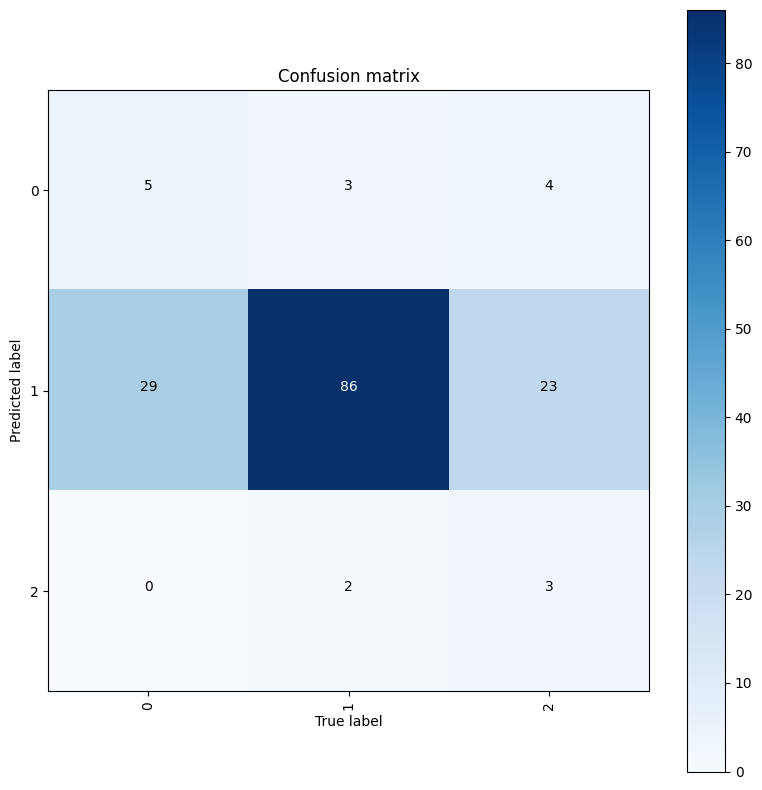

In [73]:
plot_confusion_matrix(y_valid, valid_pred,
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [ ]:
# %%time
# X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
# X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

# **Read in memory file of previous notebooks features, Truth-Fake, Sarcasm then write the new feature Stance to the memory file**

In [74]:
import csv

# Step 1: Read the existing CSV file and store its content
csv_file_path = 'data_to_graph.csv'
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'r') as file:
    reader = csv.reader(file)
    data = list(reader)

# Step 2: Define the values for the new column
new_values = valid_pred # df_new_texts['predicted_sarcasm'] # ['New York', 'Los Angeles', 'Chicago', 'San Francisco']

# Step 3: Add the new column header to the first row of the data
data[0].append('predicted_stance')

# Step 4: Add the new column values to the remaining rows of the data
for i in range(1, 154): # len(data)):
    data[i].append(new_values[i - 1])

# Step 5: Write the updated data back to the CSV file
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

# **Sample graphic to represent 3 metrics i) True vs Fake ; ii) Straight vs Sarcasm ; iii) Misinformation vs Disinformation**

<ipython-input-75-e0df9322fdab>:42: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
<ipython-input-75-e0df9322fdab>:83: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
<ipython-input-75-e0df9322fdab>:124: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5


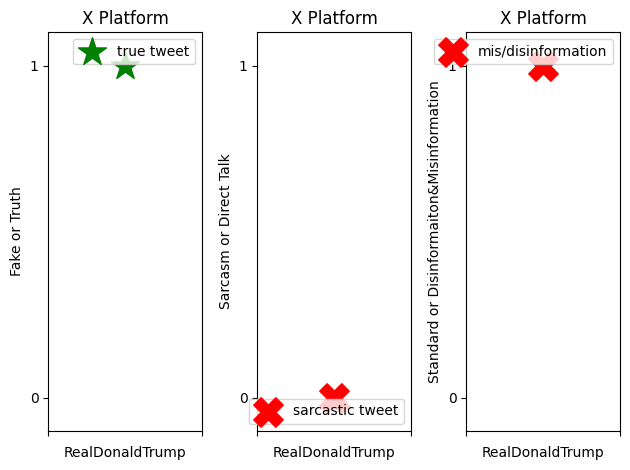

CPU time used: 0.6762959129999899 seconds


In [75]:
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA # - originally form Truth Fake module

import time
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# measure User ; Sys ; and Wall time for evaluation
#%%time
start_time = time.process_time()
# Code to measure

plt.subplot(1, 3, 1)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values

df_new_texts = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv')
y = df_new_texts['predicted_true_fake'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]

if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "fake tweet", color= "red",
            marker= "X", s=450)
  plt.legend(loc='lower left')
if y >= 0.99:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "true tweet", color= "green",
            marker= "*", s=450)
  plt.legend(loc='upper right')

# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Fake or Truth')
# plot title
plt.title('X Platform')
# showing legend
#plt.legend()
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])


plt.subplot(1, 3, 2)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
#y = df_new_texts['target'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]
#y = int(prediction[0]) # [2,4,5,7,6,8,9,11,12,12]
#y = prediction[0] # [2,4,5,7,6,8,9,11,12,12]
y = df_new_texts['predicted_sarcasm'].iloc[0]


if y >= 0.99:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "direct tweet", color= "green",
            marker= "*", s=450)
  plt.legend(loc='upper right')
if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "sarcastic tweet", color= "red",
            marker= "X", s=450)
  plt.legend(loc='lower right')

# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Sarcasm or Direct Talk')
# plot title
plt.title('X Platform')
# showing legend
#plt.legend()
#plt.legend(['Legend'], loc='upper left')
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])

# function to show the plot
#plt.show()


plt.subplot(1, 3, 3)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values

#y = predicted_value.iloc[0] # valid_pred # df_new_texts['predicted_true_fake'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]
y = df_new_texts['predicted_stance'].iloc[0]

if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "neutral tweet", color= "green",
            marker= "star", s=450)
  plt.legend(loc='lower left')
if y >= 0.99:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "mis/disinformation", color= "red",
            marker= "X", s=450)
  plt.legend(loc='upper right')

# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Standard or Disinformaiton&Misinformation')
# plot title
plt.title('X Platform')
# showing legend
#plt.legend()
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])


# function to show the plot
plt.tight_layout()
plt.show()

end_time = time.process_time()
print(f"CPU time used: {end_time - start_time} seconds")

# ** NEW long short term memory (LSTM) in Stance notebook<<- Model Improvement above TF-iDF+logit regression 70% accurate -> trying here LSTM to get higher accuracy**

In [76]:
# LSTM

# Text pre-processing
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.callbacks import EarlyStopping
# # Modeling
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional


# #!pip install keras
# import keras.preprocessing.text Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Embedding, LSTM, Dense
# from keras.models import Sequential

import keras
#import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.models import Sequential
from keras.metrics import F1Score # (average=None, threshold=None, name="f1_score", dtype=None)


# The input text, example could be list of sentences
texts = train_texts[:] # [...]

# The labels corresponding to the input text
labels = y_train[:] # train_df['label'] # train_texts['Author'] # [...]

# Hyperparameters
max_words = 10000 # max number of words to use in the vocabulary
max_len = 200 # max length of each text (in terms of number of words)
embedding_dim = 200 # dimension of word embeddings
lstm_units = 64 # number of units in the LSTM layer
num_classes = len(set(labels)) # 2 # len(y_train) # y_train.unique() # 2 # len(set(labels)) # number of classes

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts.values.astype('U'))
sequences = tokenizer.texts_to_sequences(texts.values.astype('U'))

# Pad the sequences so they all have the same length
x = pad_sequences(sequences, maxlen=max_len)

# Create one-hot encoded labels
y = keras.utils.to_categorical(labels,
                               num_classes)

# Build the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='softmax')) # 'relu'' ; "rmsprop"

# optimizer='adam', loss='mse'


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 'binary_crossentropy'

# train_texts, valid_texts, y_train, y_valid

# Train the model
model.fit(x, y, batch_size=32, epochs=7) # originally epochs=10 but reduced to 7 to meet time limit

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.4809 - loss: 1.0624
Epoch 2/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.5428 - loss: 0.9656
Epoch 3/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.6150 - loss: 0.8226
Epoch 4/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.7850 - loss: 0.5331
Epoch 5/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.8477 - loss: 0.3115
Epoch 6/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.9570 - loss: 0.1673
Epoch 7/7
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9920 - loss: 0.0637


# **Using NEW data -> predict using NEW model LSTM previously trained on reference ground truth labelled stance data**

In [77]:
# Using NEW data -> predict using NEW model LSTM prviously trained on reference ground truth labelled stance data
# write Stance prediction results to shared dataframe

import numpy as np

#X = df_new_texts['Text']

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer(num_words=max_words)
#tokenizer.fit_on_texts(texts.values.astype('U'))
tokenizer.fit_on_texts(df_new_texts['content'].values.astype('U'))
# sequences = tokenizer.texts_to_sequences(texts.values.astype('U'))
sequences = tokenizer.texts_to_sequences(df_new_texts['content'].values.astype('U'))

# Pad the sequences so they all have the same length
X = pad_sequences(sequences, maxlen=max_len)

prediction = []
prediction = model.predict(X)

# Creating multi-dimension array
#array1 = [1, 2, 4, [5, [6, 7]]]

# Object Data type is accept all data-type
Data_type = int

# Now we fix the error
#np_array = numpy.array(prediction, dtype=Data_type)
# TEMP commented out
#prediction = np.array(prediction, dtype=Data_type)
#prediction = prediction.flatten('C')


df_new_texts['predicted_stance_neutral'] = 0
df_new_texts['predicted_stance_misinformation'] = 0
df_new_texts['predicted_stance_disinformation'] = 0
df_new_texts['predicted_stance_all_types'] = 0


#for i in range(len(prediction)):
i = 0
for p in prediction[:, 0]:
  if p >= 0.50:
    #print(p)
    df_new_texts.loc[i, 'predicted_stance_neutral'] = 1
  i += 1

i = 0
for p in prediction[:, 1]:
  if p >= 0.50:
    df_new_texts.loc[i, 'predicted_stance_misinformation'] = 1
  i += 1

i = 0
for p in prediction[:, 2]:
  if p >= 0.50:
    df_new_texts.loc[i, 'predicted_stance_disinformation'] = 1
  i += 1

i = 0
#for p in prediction[:, 2]:
for i in range(len(df_new_texts)):
  if df_new_texts.loc[i, 'predicted_stance_neutral'] == 1 and df_new_texts.loc[i, 'predicted_stance_misinformation'] == 0 and df_new_texts.loc[i, 'predicted_stance_disinformation'] == 0:
    df_new_texts.loc[i, 'predicted_stance_all_types'] = 0
  if df_new_texts.loc[i, 'predicted_stance_neutral'] == 0 and df_new_texts.loc[i, 'predicted_stance_misinformation'] == 1 and df_new_texts.loc[i, 'predicted_stance_disinformation'] == 0:
    df_new_texts.loc[i, 'predicted_stance_all_types'] = 1
  if df_new_texts.loc[i, 'predicted_stance_neutral'] == 0 and df_new_texts.loc[i, 'predicted_stance_misinformation'] == 0 and df_new_texts.loc[i, 'predicted_stance_disinformation'] == 1:
    df_new_texts.loc[i, 'predicted_stance_all_types'] = 2
  i += 1


df_new_texts = df_new_texts[['id', 'content', 'clean_text', 'clean_joined_text', 'predicted_true_fake', 'predicted_sarcasm', 'predicted_stance_neutral', 'predicted_stance_misinformation', 'predicted_stance_disinformation', 'predicted_stance_all_types']].copy()

#df_new_texts.drop(index='predicted_stance', axis=0, inplace=True)
print(df_new_texts)
df_new_texts.info()
df_new_texts.describe()
print(len(prediction))
#print(len( df_new_texts['predicted_stance']))
len(X)

304/304 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step
                       id                                            content  \
0      965925223949357056  Thank you to @ foxandfriends for the great tim...   
1      965928352614965248  “There is no serious person out there who woul...   
2      965930611272712192  ....The President Obama quote just before elec...   
3      965932714141650946  Republicans are now leading the Generic Poll, ...   
4      965935035328155649  Matt Schlapp and CPAC are getting ready for an...   
...                   ...                                                ...   
9721  1273405198698975232  Joe Biden was a TOTAL FAILURE in Government. H...   
9722  1273408026968457216  Will be interviewed on @ seanhannity tonight a...   
9723  1273442195161387008                         pic.twitter.com/3lm1spbU8X   
9724  1273442469066276864                         pic.twitter.com/vpCE5MadUz   
9725  1273442528411385858                         pic.twitter.com/VLlc0BHW41 

9726

In [46]:
print(df_new_texts['predicted_stance_all_types'])

0       0
1       1
2       1
3       1
4       1
       ..
9721    1
9722    0
9723    0
9724    0
9725    0
Name: predicted_stance_all_types, Length: 9726, dtype: int64


In [47]:
df_new_texts['predicted_stance_all_types'].sum()

7658

# **IMPORTANT - Only run ONCE**

*   write feature column for neutral stance
*   write feature column for misinformation
*   write feature column for disinformation
*   write feature column for all stance types




In [78]:
# IMPORTANT - Only run ONCE
# save shared data frame with Saracasm prediction resutls added to the shared file

import csv

# # Step 1: Read the existing CSV file and store its content
# csv_file_path = 'data_to_graph.csv'
# with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'r') as file:
#     reader = csv.reader(file)
#     data = list(reader)

# # Step 2: Define the values for the new "City" column
# new_values = df_new_texts['predicted_sarcasm'] # ['New York', 'Los Angeles', 'Chicago', 'San Francisco']

# # Step 3: Add the new "City" column header to the first row of the data
# data[0].append('predicted_sarcasm')

# # Step 4: Add the new "City" column values to the remaining rows of the data
# for i in range(1, len(data)):
#     data[i].append(new_values[i - 1])

# # Step 5: Write the updated data back to the CSV file
# with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(data)


# Step 1: Read the existing CSV file and store its content
csv_file_path = 'data_to_graph.csv'
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'r') as file:
    reader = csv.reader(file)
    data = list(reader)
#Step 2 , 3, 4 repeated
new_values = df_new_texts['predicted_stance_neutral']
data[0].append('predicted_stance_neutral')
#data = data[['Author', 'Text', 'clean_text', 'clean_joined_text', 'predicted_true_fake', 'predicted_sarcasm']].copy()
for i in range(1, len(data)):
    data[i].append(new_values[i - 1])
# Step 5: Write the updated data back to the CSV file
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

# Step 1: Read the existing CSV file and store its content
csv_file_path = 'data_to_graph.csv'
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'r') as file:
    #file = file[['Author', 'Text', 'clean_text', 'clean_joined_text', 'predicted_true_fake', 'predicted_sarcasm', 'predicted_stance_neutral']].copy()
    reader = csv.reader(file)
    data = list(reader)
#Step 2, 3, 4 repeated
new_values = df_new_texts['predicted_stance_misinformation']
data[0].append('predicted_stance_misinformation')
for i in range(1, len(data)):
    data[i].append(new_values[i - 1])
# Step 5: Write the updated data back to the CSV file
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

# Step 1: Read the existing CSV file and store its content
csv_file_path = 'data_to_graph.csv'
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'r') as file:
    #file = file[['Author', 'Text', 'clean_text', 'clean_joined_text', 'predicted_true_fake', 'predicted_sarcasm', 'predicted_stance_neutral', 'predicted_stance_misinformation']].copy()
    reader = csv.reader(file)
    data = list(reader)
#Step 2, 3, 4 repeated
new_values = df_new_texts['predicted_stance_disinformation']
data[0].append('predicted_stance_disinformation')
for i in range(1, len(data)):
    data[i].append(new_values[i - 1])
# Step 5: Write the updated data back to the CSV file
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)


# Step 1: Read the existing CSV file and store its content
csv_file_path = 'data_to_graph.csv'
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'r') as file:
    #file = file[['Author', 'Text', 'clean_text', 'clean_joined_text', 'predicted_true_fake', 'predicted_sarcasm', 'predicted_stance_neutral', 'predicted_stance_misinformation', 'predicted_stance_disinformation']].copy()
    reader = csv.reader(file)
    data = list(reader)
#Step 2, 3, 4 repeated
new_values = df_new_texts['predicted_stance_all_types']
data[0].append('predicted_stance_all_types')
for i in range(1, len(data)):
    data[i].append(new_values[i - 1])
# Step 5: Write the updated data back to the CSV file
with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

# # Step 5: Write the updated data back to the CSV file
# with open('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(data)


print('predicted_sarcasm = ', df_new_texts['predicted_sarcasm'].sum())
print('predicted_stance_neutral = ', df_new_texts['predicted_stance_neutral'].sum())
print('predicted_stance_misinformation = ', df_new_texts['predicted_stance_misinformation'].sum())
print('predicted_stance_disinformation = ', df_new_texts['predicted_stance_disinformation'].sum())
print('predicted_stance_all_types = ', df_new_texts['predicted_stance_all_types'].sum())
#print(df_new_texts['predicted_stance_all_types'].value_counts)

predicted_sarcasm =  0.0
predicted_stance_neutral =  295
predicted_stance_misinformation =  8156
predicted_stance_disinformation =  893
predicted_stance_all_types =  9942


In [79]:
#print(df_new_texts.value_counts())
df_new_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9726 entries, 0 to 9725
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               9726 non-null   int64  
 1   content                          9726 non-null   object 
 2   clean_text                       9726 non-null   object 
 3   clean_joined_text                9722 non-null   object 
 4   predicted_true_fake              9726 non-null   int64  
 5   predicted_sarcasm                999 non-null    float64
 6   predicted_stance_neutral         9726 non-null   int64  
 7   predicted_stance_misinformation  9726 non-null   int64  
 8   predicted_stance_disinformation  9726 non-null   int64  
 9   predicted_stance_all_types       9726 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 760.0+ KB


# **Create and plot the version 1 chart - the side-by-side features chart**

<ipython-input-80-d73517b936ca>:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
<ipython-input-80-d73517b936ca>:88: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
<ipython-input-80-d73517b936ca>:132: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
<ipython-input-80-d73517b936ca>:178: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5


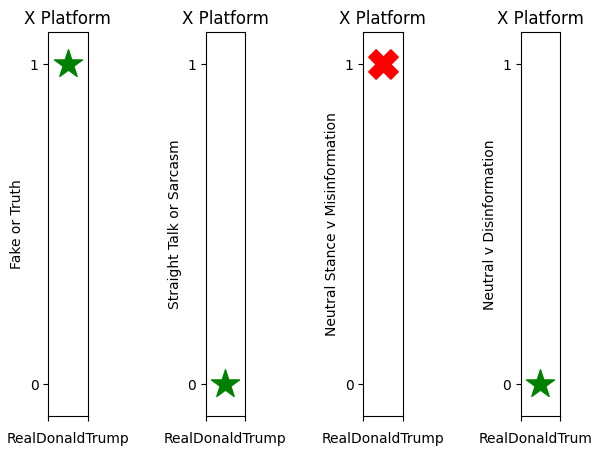

CPU time used: 0.6832544579999649 seconds


In [80]:
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA #
# TO BE POINTED AT THE NEW DATA # - originally from Truth Fake module

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import time

start_time = time.process_time()
# Code to measure


# Chart #1 - True v Fake
plt.subplot(1, 4, 1)  # row 1, column 3, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
y = df_new_texts['predicted_true_fake'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]


if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "rasberry", color= "red",
            marker= "X", s=450)
  #plt.legend(loc='lower left')

if y == 1:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "stars", color= "green",
            marker= "*", s=450)
  #plt.legend(loc='upper left')


# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Fake or Truth')
# plot title
plt.title('X Platform')
# showing legend

# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])



# Chart #2 - Sarcasm
plt.subplot(1, 4, 2)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
#y = df_new_texts['target'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]
#y = int(prediction[0]) # [2,4,5,7,6,8,9,11,12,12]
y = prediction[0] # [2,4,5,7,6,8,9,11,12,12]
#y = prediction[0, 0] # [2,4,5,7,6,8,9,11,12,12]

y = df_new_texts['predicted_sarcasm'][0]

if y >= 0.99:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "rasberry talk", color= "red",
            marker= "X", s=450)
  #plt.legend(loc='upper right')

if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "straight talk", color= "green",
            marker= "*", s=450)
  #plt.legend(loc='lower right')

# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Straight Talk or Sarcasm')
# plot title
plt.title('X Platform')
# showing legend
#plt.legend()
#plt.legend(['Legend'], loc='upper left')
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])


# Chart #3 - Misinformation
plt.subplot(1, 4, 3)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
#y = df_new_texts['target'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]
#y = int(prediction[0]) # [2,4,5,7,6,8,9,11,12,12]
y = prediction[0] # [2,4,5,7,6,8,9,11,12,12]
#y = prediction[0, 0] # [2,4,5,7,6,8,9,11,12,12]

y = df_new_texts['predicted_stance_misinformation'][0]

if y >= 0.99:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "misinformation stance", color= "red",
            marker= "X", s=450)
  #plt.legend(loc='upper right')

if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "neutral stance", color= "green",
            marker= "*", s=450)
  #plt.legend(loc='lower right')

# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Neutral Stance v Misinformation')
# plot title
plt.title('X Platform')
# showing legend
#plt.legend()
#plt.legend(['Legend'], loc='upper left')
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])




# Chart #4 - Disinformation
plt.subplot(1, 4, 4)  # row 1, column 2, count 1
# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values
#y = df_new_texts['target'].iloc[0] # [2,4,5,7,6,8,9,11,12,12]
#y = int(prediction[0]) # [2,4,5,7,6,8,9,11,12,12]
y = prediction[0] # [2,4,5,7,6,8,9,11,12,12]
#y = prediction[0, 0] # [2,4,5,7,6,8,9,11,12,12]

y = df_new_texts['predicted_stance_disinformation'][0]

if y >= 0.99:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "Disinformation Stance", color= "red",
            marker= "X", s=450)
  #plt.legend(loc='upper right')

if y == 0:
  # plotting points as a scatter plot
  plt.scatter(x, y, label= "Neutral Stance", color= "green",
            marker= "*", s=450)
  #plt.legend(loc='lower right')

# x-axis label
plt.xlabel('RealDonaldTrump')
# frequency label
plt.ylabel('Neutral v Disinformation')
# plot title
plt.title('X Platform')
# showing legend
#plt.legend()
#plt.legend(['Legend'], loc='upper left')
# Setting the axis range
plt.xlim(0,0) # (-0.5, 0.5)  # X-axis range from 0 to 5
plt.ylim(-0.1, 1.1)
plt.gca().set_xticklabels([])

#plt.set_yticklabels([str(round(float(label), 0)) for target in y])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal
plt.xticks([-1, 1])
plt.yticks([0, 1])

#plt.figsize=(10,6)
#plt.tight_layout(pad=100.0)


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=3.0,
                    hspace=15.0)

#plt.tight_layout()

# function to show the plot
#plt.show()

from matplotlib import pyplot as plt
plt.savefig('/content/drive/My Drive/Colab_Notebooks/MSCAITOP/MSCAITOP_graphic_v1.png', bbox_inches='tight')

# function to show the plot
plt.show()

end_time = time.process_time()

print(f"CPU time used: {end_time - start_time} seconds")

# **NEW combined chart**

# **Plot version 2 chart - the combined features chart**

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


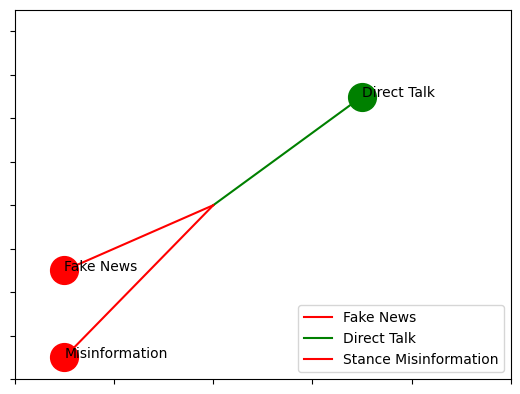

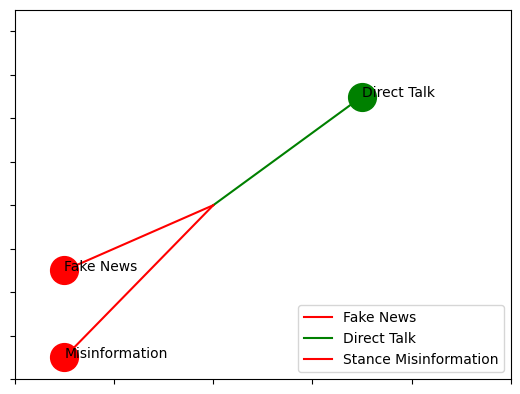

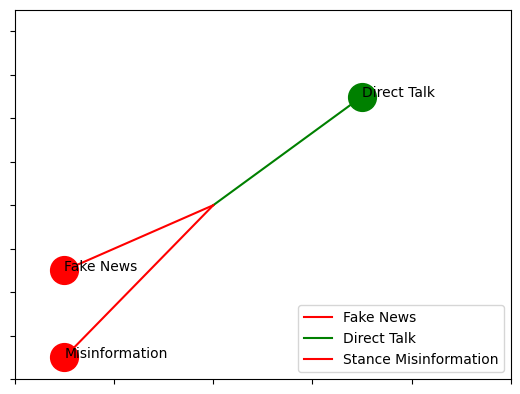

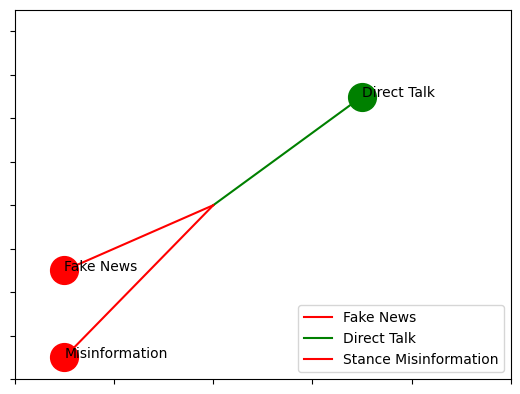

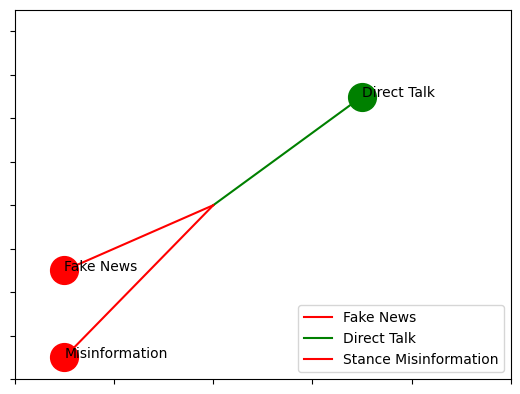

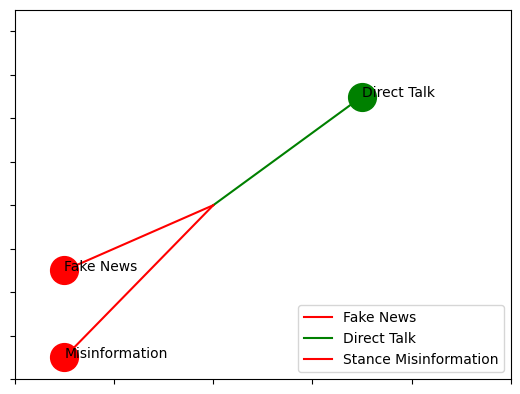

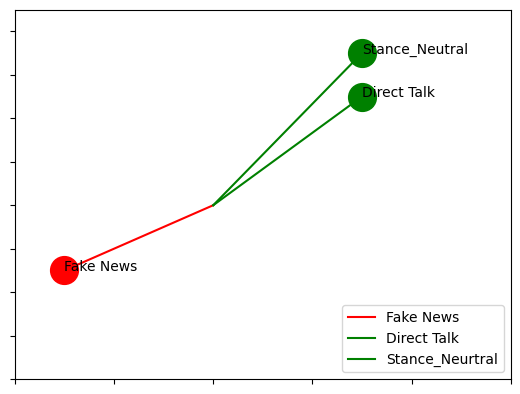

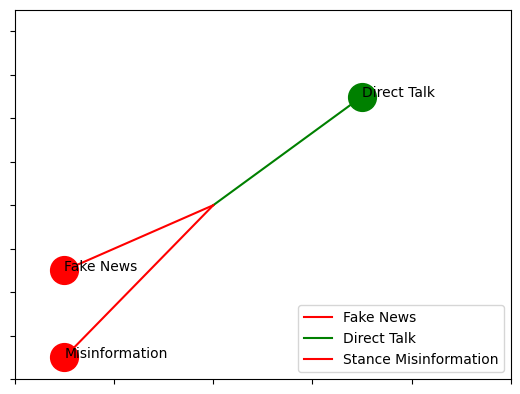

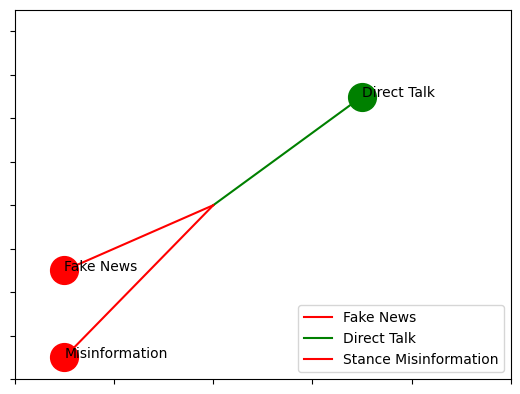

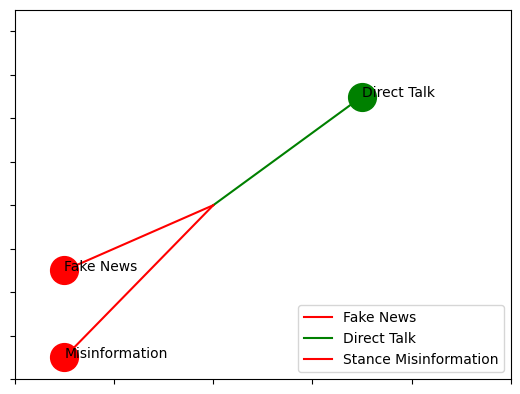

Total for batch of  10  charts - the Total CPU time used: {4.756256296000004} seconds
Per chart CPU time used: 0.4756256296000004 seconds


In [81]:
# NEW combined chart

# importing package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import StrMethodFormatter

import io
import xml.etree.ElementTree as ET
import time

from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D

from google.colab import drive
drive.mount('/content/drive/')

# x-axis values
x = [0] # [1,2,3,4,5,6,7,8,9,10]
# y-axis values

# measure User ; Sys ; and Wall time for evaluation

start_time = time.process_time()
# Code to measure

df_new_texts = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/MSCAITOP/data_to_graph.csv')


for i in range(10):
  y1 = df_new_texts['predicted_true_fake'].iloc[i] # [2,4,5,7,6,8,9,11,12,12]
  y2 = df_new_texts['predicted_sarcasm'].iloc[i]
  #y3 = df_new_texts['predicted_stance_neutral'].iloc[i]
  y3 = df_new_texts['predicted_stance_all_types'].iloc[i]

  # 'predicted_stance_misinformation'
  # 'predicted_stance_disinformation'

  #y4 = df_new_texts['predicted_stance_misinformation'].iloc[0]
  #y5 = df_new_texts['predicted_stance_disinformation'].iloc[0]

  # create data
  # x = [1,2,3,4,5]
  # y = [3,3,3,3,3]

  # text_style = dict(horizontalalignment='right', verticalalignment='center',
  #                   fontsize=12, fontfamily='monospace')
  # marker_style = dict(linestyle=':', color='0.8', markersize=10,
  #                     markerfacecolor="tab:blue", markeredgecolor="tab:blue")

  # y1 = [0]
  # y2 = [0]
  # y3 = [0]
  # all good / all zeros / true news 0 / straight talk 0/ neutral stance 0
  if y1 == [0] and y2 == [0] and y3 == [0]:
    #print('Test = if block runs')
    # plot lines
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(-3, -7, 'True News')
    x2 = [3,0]
    y2 = [5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Direct Talk", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(-3, -7, 'Direct Talk')
    x3 = [3,0]
    y3 = [7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance_Neutral", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 7, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(-3, -7, 'Stance Neutral')


  # y1 = [1]
  # y2 = [1]
  # y3 = [1]
  # all up / all ones / all fake 1 / sarcasm 1/ all misinformation 1
  if y1 == [1] and y2 == [1] and y3 == [1]:
    #print('Test = if block runs')
    # plot lines
    x1 = [-3,0]
    y1 = [-3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "Fake News", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -3, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -3, 'Fake News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Sarcasm')
    x3 = [-3,0]
    y3 = [-7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Misinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -7, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -7, 'Misinformation')

  # y1 = [1]
  # y2 = [0]
  # y3 = [1]
  # all good / all zeros / true news 0 / straight talk 0/ neutral stance 0
  if y1 == [1] and y2 == [0] and y3 == [1]:
    #print('Test = if block runs')
    # plot lines
    x1 = [-3,0]
    y1 = [-3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "Fake News", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -3, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -3, 'Fake News')
    x2 = [3,0]
    y2 = [5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Direct Talk", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 5, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 5, 'Direct Talk')
    x3 = [-3,0]
    y3 = [-7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance Misinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -7, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -7, 'Misinformation')

  # y1 = [0]
  # y2 = [0]
  # y3 = [1]
  # Mixed / all fake 0/sarcasm 0/all misinformation&disinformation 1
  if y1 == [0] and y2 == [0] and y3 == [1]:
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 3, 'True News')
    x2 = [3,0]
    y2 = [5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Direct Talk", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 5, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 5, 'Direct Talk')
    x3 = [-3,0]
    y3 = [-7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Misinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -7, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -7, 'Misinformation')

    plt.legend(loc='lower right')
    from matplotlib import pyplot as plt
    plt.savefig('/content/drive/My Drive/Colab_Notebooks/MSCAITOP/MSCAITOP_graphic_v2a.png', bbox_inches='tight')


  # y1 = [0]
  # y2 = [1]
  # y3 = [1]
  # passed testing
  # Mixed / all fake 0/sarcasm 1/all misinformation&disinformation 1
  if y1 == [0] and y2 == [1] and y3 == [1]:
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 3, 'True News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm Talk", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Sarcasm Talk')
    x3 = [-3,0]
    y3 = [-7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Misinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -7, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -7, 'Misinformation')

  # y1 = [0]
  # y2 = [1]
  # y3 = [0]
  # Mixed / all fake 0/sarcasm 1/all misinformation&disinformation 0
  if y1 == [0] and y2 == [1] and y3 == [0]:
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 3, 'True News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm Talk", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Sarcasm Talk')
    x3 = [3,0]
    y3 = [7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance_Neutral", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 7, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 7, 'Stance_Neutral')

  # y1 = [1]
  # y2 = [1]
  # y3 = [0]
  # Mixed / all fake 1/sarcasm 1/all misinformation&disinformation 0
  if y1 == [1] and y2 == [1] and y3 == [0]:
    x1 = [-3,0]
    y1 = [-3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "Fake News", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -3, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -3, 'Fake News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm Talk", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Saracasm Talk')
    x3 = [3,0]
    y3 = [7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance_Neutral", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 7, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 7, 'Stance_Neutral')

  # y1 = [1]
  # y2 = [1]
  # y3 = [0]
  # Mixed / all fake 1/sarcasm 1/all misinformation&disinformation 0
  if y1 == [1] and y2 == [1] and y3 == [0]:
    x1 = [-3,0]
    y1 = [-3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "Fake News", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -3, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -3, 'Fake News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm Talk", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Sarcasm Talk')
    x3 = [3,0]
    y3 = [7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance_Neurtral", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 7, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 7, 'Stance_Neutral')

  # y1 = [1]
  # y2 = [0]
  # y3 = [0]
  #passed testing
  # Mixed / all fake 1/sarcasm 0/all misinformation&disinformation 0
  if y1 == [1] and y2 == [0] and y3 == [0]:
    x1 = [-3,0]
    y1 = [-3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "Fake News", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -3, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -3, 'Fake News')
    x2 = [3,0]
    y2 = [5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Direct Talk", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 5, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 5, 'Direct Talk')
    x3 = [3,0]
    y3 = [7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance_Neurtral", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 7, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 7, 'Stance_Neutral')



  plt.xlim(-4, 6)
  plt.ylim(-8, 9)
  plt.gca().set_xticklabels([])
  plt.gca().set_yticklabels([])

  # y1 = [0]
  # y2 = [0]
  # y3 = [1]
  # Mixed / all fake 0/sarcasm 0/all misinformation&disinformation 1
  if y1 == [0] and y2 == [0] and y3 == [1]:
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 3, 'True News')
    x2 = [3,0]
    y2 = [5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Direct Talk", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 5, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 5, 'Direct Talk')
    x3 = [-3,0]
    y3 = [-7,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance Misinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -7, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -7, 'Stance Misinformation')


  # *** NEW for 0,1,2 single feature for stance column ***
  # y1 = [0]
  # y2 = [0]
  # y3 = [2]
  # Mixed / all fake 0/sarcasm 0/all misinformation&disinformation 1
  if y1 == [0] and y2 == [0] and y3 == [2]:
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 3, 'True News')
    x2 = [3,0]
    y2 = [5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Direct Talk", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 5, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 5, 'Direct Talk')
    x3 = [-3,0]
    y3 = [-9,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance Disinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -9, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -9, 'Stance Disinformation')

  # y1 = [0]
  # y2 = [1]
  # y3 = [2]
  # Mixed / all fake 0/sarcasm 0/all misinformation&disinformation 1
  if y1 == [0] and y2 == [1] and y3 == [2]:
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 3, 'True News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm Talk", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Sarcasm Talk')
    x3 = [-3,0]
    y3 = [-9,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance Disinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -9, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -9, 'Stance Disinformation')

  # y1 = [1]
  # y2 = [1]
  # y3 = [2]
  # Mixed / all fake 0/sarcasm 0/all misinformation&disinformation 1
  if y1 == [1] and y2 == [1] and y3 == [2]:
    x1 = [-3,0]
    y1 = [-3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "Fake News", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -3, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -3, 'Fake News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm Talk", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Sarcasm Talk')
    x3 = [-3,0]
    y3 = [-9,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance Disinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -9, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -9, 'Stance Disinformation')

  # y1 = [1]
  # y2 = [0]
  # y3 = [2]
  # Mixed / all fake 0/sarcasm 0/all misinformation&disinformation 1
  if y1 == [1] and y2 == [0] and y3 == [2]:
    x1 = [-3,0]
    y1 = [-3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "Fake News", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -3, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -3, 'Fake News')
    x2 = [3,0]
    y2 = [5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Direct Talk", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 5, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 5, 'Direct Talk')
    x3 = [-3,0]
    y3 = [-9,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance Disinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -9, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -9, 'Stance Disinformation')

  # y1 = [0]
  # y2 = [1]
  # y3 = [2]
  # Mixed / all fake 0/sarcasm 0/all misinformation&disinformation 1
  if y1 == [0] and y2 == [1] and y3 == [2]:
    x1 = [3,0]
    y1 = [3,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x1, y1, label = "True News", color='green') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(3, 3, marker="o", markersize=20, markeredgecolor="green", markerfacecolor="green")
    plt.text(3, 3, 'True News')
    x2 = [-3,0]
    y2 = [-5,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x2, y2, label = "Sarcasm Talk", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -5, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -5, 'Sarcasm Talk')
    x3 = [-3,0]
    y3 = [-9,0]
    #plt.plot(x1, y1, label = "line 1", marker='<', markersize=20, color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(x3, y3, label = "Stance Disinformation", color='red') # , **marker_style, **text_style)  # linestyle="-", color='red'
    plt.plot(-3, -9, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
    plt.text(-3, -9, 'Stance Disinformation')

  plt.legend(loc='lower right')

  from matplotlib import pyplot as plt
  plt.savefig('/content/drive/My Drive/Colab_Notebooks/MSCAITOP/MSCAITOP_graphic_v2b.png', bbox_inches='tight')

  plt.show()

  # l1, = ax.plot([0.1, 0.5, 0.9], [0.1, 0.9, 0.5], "bo-",
  #               mec="b", lw=5, ms=10, label="Line 1")


end_time = time.process_time()

print(f"Total for batch of ", i + 1, " charts - the Total CPU time used:", {end_time - start_time}, "seconds")
print(f"Per chart CPU time used: {(end_time - start_time) / (i + 1)} seconds")


# **Sample of 10 records of the data along with all features: Truth-Fake, Sarcasm, Stance**

In [82]:
 df_new_texts[:10]

,Unnamed: 0,id,content,clean_text,clean_joined_text,predicted_true_fake,predicted_sarcasm,predicted_stance,predicted_stance_neutral,predicted_stance_misinformation,predicted_stance_disinformation,predicted_stance_all_types
0,0,965925223949357056,Thank you to @ foxandfriends for the great tim...,"['thank', 'foxandfriends', 'great', 'timeline'...",thank foxandfriends great timeline failures ob...,1,0,1,0,1,0.0,1.0
1,1,965928352614965248,“There is no serious person out there who woul...,"['person', 'suggest', 'rig', 'america', 'elect...",person suggest rig america elections evidence ...,1,0,1,0,1,0.0,1.0
2,2,965930611272712192,....The President Obama quote just before elec...,"['president', 'obama', 'quote', 'election', 't...",president obama quote election thought crooked...,1,0,1,0,1,0.0,1.0
3,3,965932714141650946,"Republicans are now leading the Generic Poll, ...","['republicans', 'leading', 'generic', 'poll', ...",republicans leading generic poll popular tax c...,1,0,2,0,1,0.0,1.0
4,4,965935035328155649,Matt Schlapp and CPAC are getting ready for an...,"['matt', 'schlapp', 'cpac', 'getting', 'ready'...",matt schlapp cpac getting ready exciting event...,1,0,1,0,1,0.0,1.0
5,5,965937068907073536,Hope Republicans in the Great State of Pennsyl...,"['hope', 'republicans', 'great', 'state', 'pen...",hope republicans great state pennsylvania chal...,1,0,1,0,1,0.0,1.0
6,6,965943827931549696,"I have been much tougher on Russia than Obama,...","['tougher', 'russia', 'obama', 'look', 'facts'...",tougher russia obama look facts total fake news,1,0,1,1,0,0.0,0.0
7,7,965968309358333952,"A woman I don’t know and, to the best of my kn...","['woman', 'know', 'best', 'knowledge', 'met', ...",woman know best knowledge met page fake news w...,1,0,1,0,1,0.0,1.0
8,8,965971586913374208,....cameras running. Another False Accusation....,"['cameras', 'running', 'false', 'accusation', ...",cameras running false accusation washingtonpos...,1,0,1,0,1,0.0,1.0
9,9,966006815745040384,Main Street is BOOMING thanks to our incredibl...,"['main', 'street', 'booming', 'thanks', 'incre...",main street booming thanks incredible tax cut ...,1,0,1,0,1,0.0,1.0


# **Correlation matrix of the features Truth-Fake, Sarcasm, Stance**

In [83]:
#df_new_texts

from sklearn import datasets
import pandas as pd

columns = ['predicted_true_fake',	'predicted_sarcasm',	'predicted_stance',	'predicted_stance_neutral',	'predicted_stance_misinformation',	'predicted_stance_disinformation',	'predicted_stance_all_types']

#load iris dataset
#dataset = datasets. load_iris ()
#dataframe = pd. DataFrame (data = dataset. data, columns = dataset. feature_names)
dataframe = pd.DataFrame (data = df_new_texts, columns = columns)
#dataframe ["target"] = dataset. target

#correlation matrix
matrix = dataframe.corr()
print(matrix)

                                 predicted_true_fake  predicted_sarcasm  \
predicted_true_fake                         1.000000          -0.022206   
predicted_sarcasm                          -0.022206           1.000000   
predicted_stance                           -0.130727          -0.299046   
predicted_stance_neutral                    0.165314          -0.074528   
predicted_stance_misinformation            -0.231405          -0.324928   
predicted_stance_disinformation                  NaN                NaN   
predicted_stance_all_types                       NaN                NaN   

                                 predicted_stance  predicted_stance_neutral  \
predicted_true_fake                     -0.130727                  0.165314   
predicted_sarcasm                       -0.299046                 -0.074528   
predicted_stance                         1.000000                 -0.796083   
predicted_stance_neutral                -0.796083                  1.000000   
pred

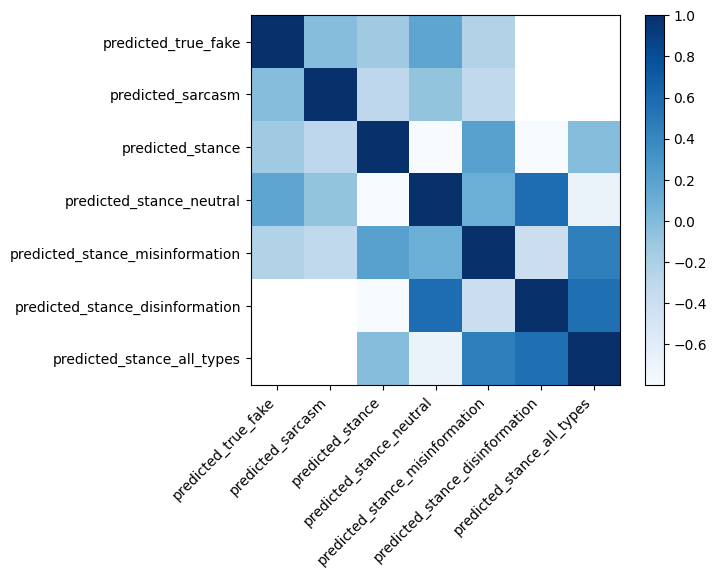

In [84]:
# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()